<a href="https://colab.research.google.com/github/LeonelH/Cats_vs_Dogs/blob/main/CatsvsDogsClassi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [ ]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [ ]:
filenames=os.listdir("/content/drive/My Drive/School/dataset/train2/")

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

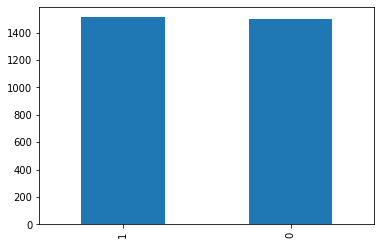

In [ ]:
df['category'].value_counts().plot.bar()

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 2,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [ ]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df, validate_df = train_test_split(df,test_size=0.20,
  random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "/content/drive/My Drive/School/dataset/train2",
                                                 x_col='filename',
                                                 y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/My Drive/School/dataset/train2", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2409 validated image filenames belonging to 2 classes.
Found 603 validated image filenames belonging to 2 classes.


In [ ]:
epochs = 10
np.random.seed()
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
160/160 [==============================] - 1022s 6s/step - loss: 1.1402 - accuracy: 0.5602 - val_loss: 2.3839 - val_accuracy: 0.4733
Epoch 2/10
160/160 [==============================] - 128s 801ms/step - loss: 0.8866 - accuracy: 0.5614 - val_loss: 0.7804 - val_accuracy: 0.5383
Epoch 3/10
160/160 [==============================] - 130s 810ms/step - loss: 0.7641 - accuracy: 0.5990 - val_loss: 0.6573 - val_accuracy: 0.6200
Epoch 4/10
160/160 [==============================] - 128s 802ms/step - loss: 0.6748 - accuracy: 0.6316 - val_loss: 0.7281 - val_accuracy: 0.5850
Epoch 5/10
160/160 [==============================] - 133s 829ms/step - loss: 0.6254 - accuracy: 0.6746 - val_loss: 0.5812 - val_accuracy: 0.6867
Epoch 6/10
160/160 [==============================] - 127s 796ms/step - loss: 0.6099 - accuracy: 0.6876 - val_loss: 0.6609 - val_accuracy: 0.6767
Epoch 7/10
160/160 [==============================] - 128s 800ms/step - loss: 0.5683 - accuracy: 0.7147 - val_loss: 0.5439 - v

In [ ]:
model.save("model1_catsVSdogs_10epoch.h5")

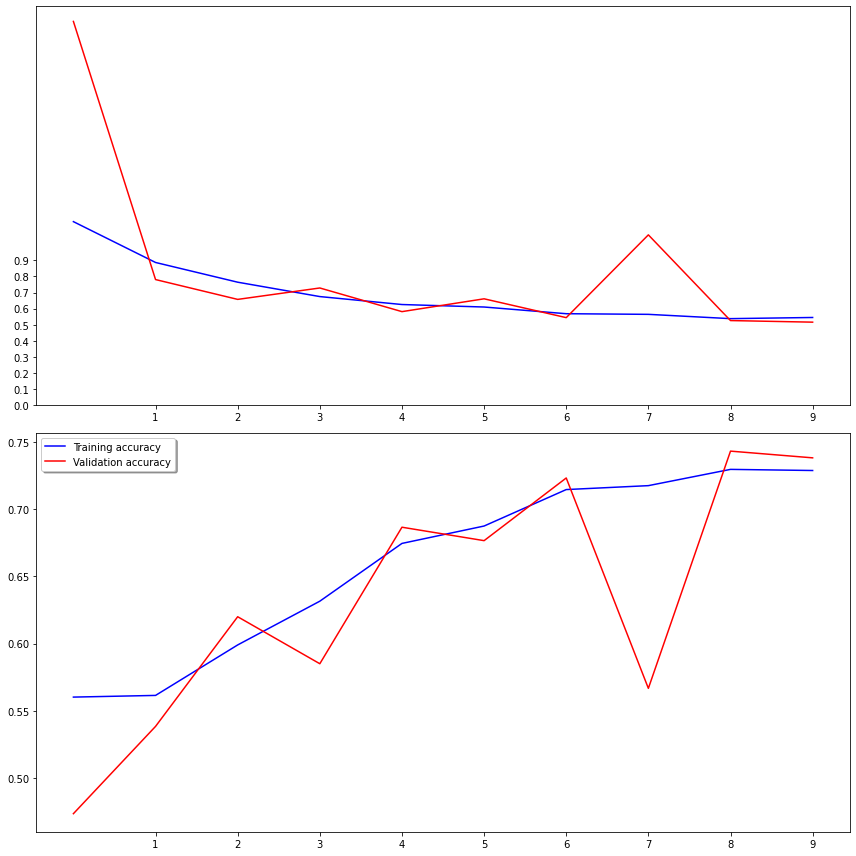

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
test_filenames = os.listdir("/content/drive/My Drive/School/dataset/test2")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                 "/content/drive/My Drive/School/dataset/test2",
                                                 x_col='filename',
                                                 y_col=None,
                                                 target_size=Image_Size,
                                                 class_mode=None,
                                                 batch_size=batch_size,
                                                 shuffle=False
                                                  )

Found 1079 validated image filenames.


In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['category'] = np.argmax(predict, axis= -1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

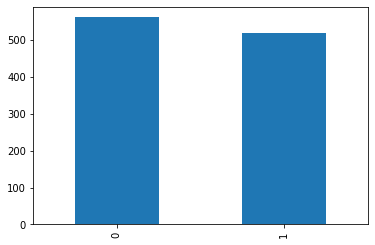

In [ ]:
test_df['category'].value_counts().plot.bar()

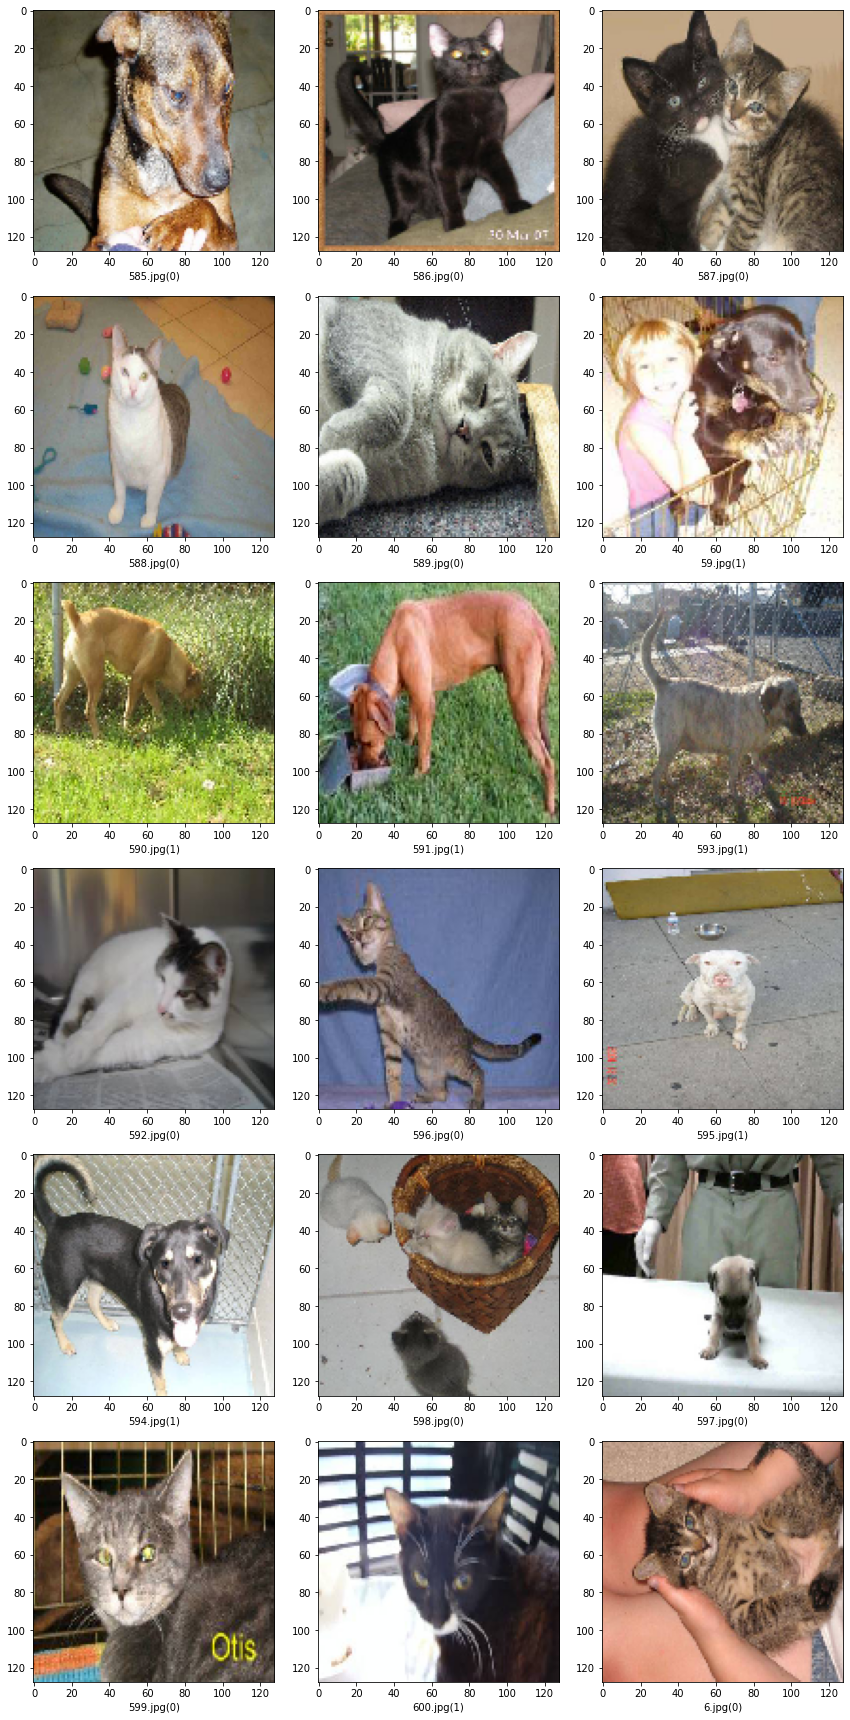

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/My Drive/School/dataset/test2/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy

from keras.models import load_model
model = load_model('model1_catsVSdogs_10epoch.h5')
#dictionary to label all traffic signs class.
classes = { 
    0:'its a cat',
    1:'its a dog',
 
}
#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('CatsVSDogs Classification')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)

def classify(file_path):
  global label_packed
  image = Image.open(file_path)
  image = image.resize((128,128))
  image = numpy.expand_dims(image, axis=0)
  image = numpy.array(image)
  image = image/255
  pred = model.predict_classes([image])[0]
  sign = classes[pred]
  print(sign)
  label.configure(foreground='#011638', text=sign) 

def show_classify_button(file_path):
  classify_b=Button(top,text="Classify Image",
  command=lambda: classify(file_path),
  padx=10,pady=5)
  classify_b.configure(background='#364156', foreground='white',
  font=('arial',10,'bold'))
  classify_b.place(relx=0.79,rely=0.46)

def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),
    (top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass
upload=Button(top,text="Upload an image",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="CatsVSDogs Classification",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()

TclError: ignored

In [ ]:
python3 gui.py